In [19]:
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
import seaborn as sns

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem

from PM import *
%matplotlib inline

In [20]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
#FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'
FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0', 'x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph',
       'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph', 'name',
       'depth', 'x_clhs', 'y_clhs', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
       'TOC', 'humus', 'bd', 'vwc', 'copeky', 'temp', 'rperm', 'iperm'],
      dtype='object')

               x         y         z         t    HCP0.5    PRP0.6    HCP1.0  \
x       1.000000 -0.729876  0.961395  0.893921  0.197529 -0.148591  0.410646   
y      -0.729876  1.000000 -0.879537 -0.347463 -0.718163 -0.500173 -0.813626   
z       0.961395 -0.879537  1.000000  0.742445  0.378195  0.062698  0.562615   
t       0.893921 -0.347463  0.742445  1.000000 -0.198070 -0.527067  0.029314   
HCP0.5  0.197529 -0.718163  0.378195 -0.198070  1.000000  0.918614  0.968304   
PRP0.6 -0.148591 -0.500173  0.062698 -0.527067  0.918614  1.000000  0.793952   
HCP1.0  0.410646 -0.813626  0.562615  0.029314  0.968304  0.793952  1.000000   
PRP1.1 -0.051822 -0.563108  0.153709 -0.438525  0.963776  0.984822  0.872549   
HCP2.0  0.731217 -0.884748  0.813273  0.422318  0.781543  0.481657  0.909271   
PRP2.1  0.342395 -0.781621  0.507822 -0.044057  0.976112  0.824542  0.994178   
ph-eau  0.116315 -0.345379  0.211629 -0.069996  0.385351  0.335985  0.392966   
CEC    -0.512830 -0.006942 -0.368007 -0.

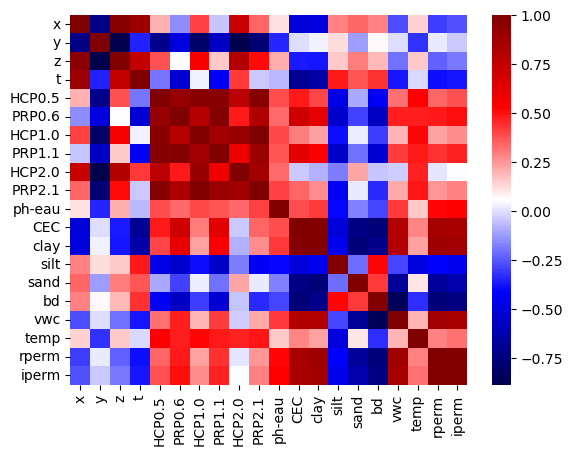

In [21]:
ds_f = ds[['x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm']]
print(ds_f.corr()) 
  
# plotting correlation heatmap 
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic") 
  
# displaying heatmap 
plt.show() 

In [22]:
results_r2 = pd.DataFrame(columns=['Aparent_HCP', 'Aparent_PRP', 'Inverted', 'Inverted_ERT'],
                  index=range(1, 4))

results_rmse = pd.DataFrame(columns=['Aparent_HCP', 'Aparent_PRP', 'Inverted', 'Inverted_ERT'],
                  index=range(1, 4))

## Aparent data // Water

In [23]:
X = ds[['HCP0.5', 'HCP1.0']]
Y = ds.vwc.values
iters = 100
RMSE_test_pol, R2_test_pol = [], []
RMSE_train_pol, R2_train_pol = [], []

for n in range(4):
    poly = PolynomialFeatures(degree=n)
    poly.fit(X)
    X_t = poly.transform(X)/1000
    X_train_t = X_t[:20]
    X_test_t = X_t[20:]
    y_train_t = Y[:20]
    y_test_t = Y[20:] 

    LinReg = LinearRegression() # call an instance of the class LinearRegression

    LinReg.fit(X_train_t, y_train_t) # fit the model on the training data

    R2_train_t = round(LinReg.score(X_train_t, y_train_t), 3) # Training set R²
    y_hat_test_t = LinReg.predict(X_test_t)

    R2_test_t = round(r2_score(y_test_t, y_hat_test_t), 3) 
    rmse_test_t = round(rmse(y_test_t, y_hat_test_t), 3) 
    RMSE_test_pol.append(rmse_test_t)
    R2_test_pol.append(R2_test_t)
    R2_train_pol.append(R2_train_t)

results_r2.Aparent_HCP[1] = R2_train_pol[R2_test_pol.index(max(R2_test_pol))]
results_r2.Aparent_HCP[2] = max(R2_test_pol)
#results_rmse.Aparent_HCP[1] = RMSE_train_pol[RMSE_test_pol.index(max(RMSE_test_pol))]
results_rmse.Aparent_HCP[2] = min(RMSE_test_pol)
results_rmse

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
1,NaN,NaN,NaN,NaN
2,0.072,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


In [24]:
X = ds[['PRP0.6', 'PRP1.1']]
Y = ds.vwc.values
iters = 100
RMSE_test_pol, R2_test_pol = [], []
RMSE_train_pol, R2_train_pol = [], []

for n in range(4):
    poly = PolynomialFeatures(degree=n)
    poly.fit(X)
    X_t = poly.transform(X)/1000
    X_train_t = X_t[:20]
    X_test_t = X_t[20:]
    y_train_t = Y[:20]
    y_test_t = Y[20:] 

    LinReg = LinearRegression() # call an instance of the class LinearRegression

    LinReg.fit(X_train_t, y_train_t) # fit the model on the training data

    R2_train_t = round(LinReg.score(X_train_t, y_train_t), 3) # Training set R²
    y_hat_test_t = LinReg.predict(X_test_t)

    R2_test_t = round(r2_score(y_test_t, y_hat_test_t), 3) 
    R2_test_pol.append(R2_test_t)
    R2_train_pol.append(R2_train_t)

results.Aparent_PRP[1] = R2_train_pol[R2_test_pol.index(max(R2_test_pol))]
results.Aparent_PRP[2] = max(R2_test_pol)
results

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
1,0.289,0.24,NaN,NaN
2,-0.019,0.153,NaN,NaN
3,-0.149612,-0.128958,NaN,NaN


In [25]:
offset = 4
water_perm = 80
ds['bulk_ec_hp'] = logsdon(50e6, ds.rperm, ds.iperm)

def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds['bulk_ec_dc_hp'] = bulk_ec_dc_hp
ds['water_ec_hp'] = Hilhorst(ds.bulk_ec_hp, ds.rperm, water_perm, offset)

col = 'HCP0.5'
HCP05_dc = []

for i in range(len(ds[col].values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds[col][i]/1000), bounds=[(0, 1)])
    HCP05_dc.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

# Defining minimization function to obtain water using Fu
def objective_func_wat(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec, EC):
    return (Fu(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec) - EC)**2
wat = []

# Calculating water
for i in range(len(HCP05_dc)):
    res = minimize(objective_func_wat, 0.15, args=(ds.clay.mean(), ds.bd.mean(), 2.65, ds.water_ec_hp.mean(), 0, np.nan, np.nan, HCP05_dc[i]), bounds=[(0, .65)] )
    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

results.Aparent_HCP[3] = r2_score(ds.vwc.values, wat)
results

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
1,0.289,0.24,NaN,NaN
2,-0.019,0.153,NaN,NaN
3,-0.149612,-0.128958,NaN,NaN


In [26]:
offset = 4
water_perm = 80
ds['bulk_ec_hp'] = logsdon(50e6, ds.rperm, ds.iperm)

def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds['bulk_ec_dc_hp'] = bulk_ec_dc_hp
ds['water_ec_hp'] = Hilhorst(ds.bulk_ec_hp, ds.rperm, water_perm, offset)

col = 'PRP1.1'

HCP05_dc = []

for i in range(len(ds[col].values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds[col][i]/1000), bounds=[(0, 1)])
    HCP05_dc.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )



# Calculating water
wat = []
for i in range(len(HCP05_dc)):
    res = minimize(objective_func_wat, 0.15, args=(ds.clay.mean(), ds.bd.mean(), 2.65, ds.water_ec_hp.mean(), 0, np.nan, np.nan, HCP05_dc[i]), bounds=[(0, .65)] )
    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

results.Aparent_PRP[3] = r2_score(ds.vwc.values, wat)
results

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
1,0.289,0.24,NaN,NaN
2,-0.019,0.153,NaN,NaN
3,-0.149612,-0.128958,NaN,NaN


## Inverted data // Water

In [27]:
depths_in = [0.1, 0.5, 0.8, 1.5]
# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9000,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)

# Run the inversion
sample_transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
print(ds_inv)
selected_columns_ds = pd.concat([ds.iloc[:, 3:11], ds.iloc[:, 17:]], axis=1)

print('selected_columns_ds', selected_columns_ds)
ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 811.24it/s]


   Finished inversion
             x           y    EC_0.10    EC_0.50    EC_0.80     EC_1.50  \
0   107720.118  183326.960  45.448942  48.947940  53.686774   56.648679   
1   107755.589  183331.100  18.683630  24.257659  36.104727   46.946926   
2   107797.402  183278.579  51.657542  63.007483  85.832548  105.981193   
3   107763.816  183318.112  13.979695  18.749940  30.016707   40.952421   
4   107723.005  183309.182  53.972187  57.344682  60.773075   61.962699   
5   107742.651  183330.207  29.209724  34.014484  42.740041   49.908003   
6   107805.822  183273.987  43.907728  56.973752  84.667845  110.062191   
7   107758.685  183312.601  19.884984  24.715865  35.361103   45.200815   
8   107776.692  183310.756  26.076176  35.193321  54.807091   72.916852   
9   107726.371  183318.719  57.899791  62.699918  68.020180   70.268443   
10  107720.118  183326.960  45.448942  48.947940  53.686774   56.648679   
11  107755.589  183331.100  18.683630  24.257659  36.104727   46.946926   
12 

In [28]:
ds_all.tail()

,x,y,EC_0.10,EC_0.50,EC_0.80,EC_1.50,EC_end,z,t,HCP0.5,...,humus,bd,vwc,copeky,temp,rperm,iperm,bulk_ec_hp,bulk_ec_dc_hp,water_ec_hp
25,107766.469,183327.314,15.203646,20.938510,34.242904,47.124332,56.895348,27.179549,42851.76,20.451035,...,2.8,1.635,0.25340,19,23.3,16.3,7.3,0.016559,0.00384,0.107702
26,107777.021,183299.370,29.255256,39.309681,60.519936,79.822799,93.030019,27.850000,42500.46,34.432702,...,2.7,1.602,0.26763,404,22.6,15.7,8.4,0.017889,0.00457,0.122315
27,107752.330,183298.809,45.988099,52.037058,61.906105,69.294681,72.560085,27.450000,41407.83,38.671301,...,3.8,1.588,0.23165,416,23.0,13.4,10.4,0.018609,0.00498,0.158372
28,107732.660,183327.436,36.630038,44.024969,57.644052,68.945343,75.426105,26.554154,41420.95,34.462790,...,3.8,1.578,0.27103,21,24.9,24.6,19.6,0.034569,0.01487,0.134247
29,107776.543,183291.428,40.455377,49.912667,68.966711,85.861675,96.961895,27.950000,42241.07,41.135917,...,2.8,1.679,0.27536,422,23.0,20.6,12.5,0.025258,0.00906,0.121727


ds_all_10cm.clay.mean() 16.482266666666664
ds_all_10cm.bulk_ec_dc_010[1] 0.01732


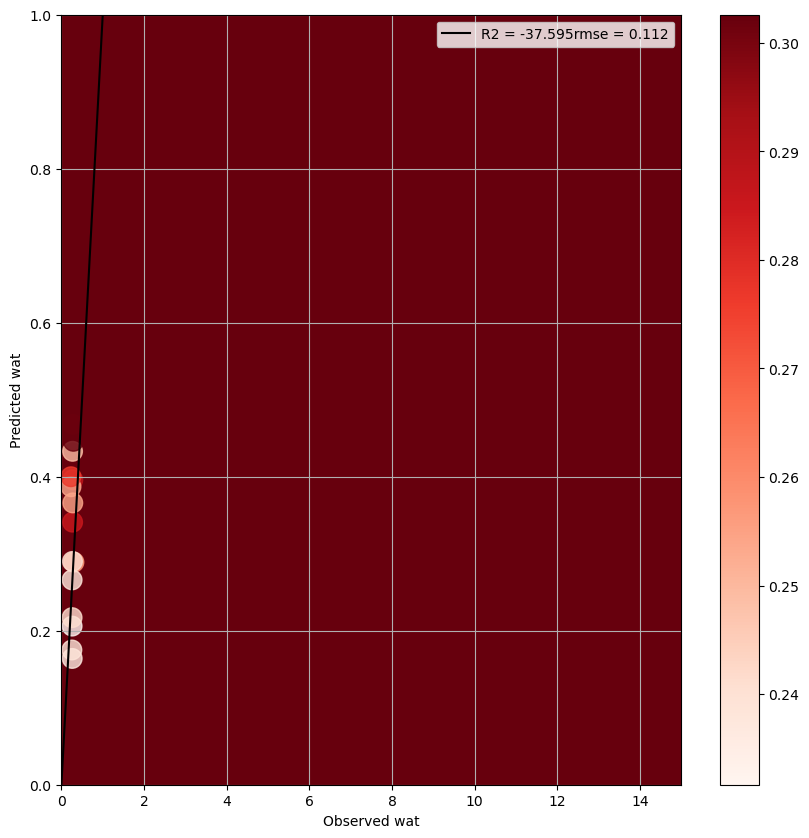

In [29]:
bulk_ec_dc_010 = []

for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.10'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_010.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_010'] = bulk_ec_dc_010
ds_all_10cm = ds_all.loc[ds_all['depth']==10].reset_index(drop=True)
print('ds_all_10cm.clay.mean()', ds_all_10cm.clay.mean() )
print('ds_all_10cm.bulk_ec_dc_010[1]', ds_all_10cm.bulk_ec_dc_010[1])

wat = []
# Calculating water
for i in range(len(ds_all_10cm.bulk_ec_dc_010)):
    res = minimize(objective_func_wat, 0.15, args=(ds_all_10cm.clay.mean(), ds_all_10cm.bd.mean(), 2.65, ds_all_10cm.water_ec_hp.mean(), 0, np.nan, np.nan, ds_all_10cm.bulk_ec_dc_010[i]), bounds=[(0, .65)] )
    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )


r2_10cm = r2_score(ds_all_10cm.vwc.values, wat)
rmse_10cm = rmse(ds_all_10cm.vwc.values, wat)

# ************************************ PLOT *********************************** #
scale =  ds_all_10cm.clay
#pcm = axes.pcolormesh([scale], vmin=np.min(ds_all_10cm.vwc), vmax=np.max(ds_all_10cm.vwc), cmap='Reds')

fig, axes = plt.subplots(figsize=[10, 10])
ss = 200
pcm = axes.pcolormesh([scale], vmin=np.min(ds_all_10cm.vwc), vmax=np.max(ds_all_10cm.vwc), cmap='Reds')

ax_lab = fig.colorbar(pcm, extend="neither", ax=axes)

# Plot predicted property vs EC
axes.scatter(ds_all_10cm.vwc, wat, s = ss, alpha=0.8, c = scale[:15], cmap = 'Reds')

axes.plot([0, 1], [0, 1], color = 'black', label = 'R2 = '+str(round(r2_10cm, 3)) + 'rmse = '+str(round(rmse_10cm, 3)))
axes.set_xlabel("Observed wat")
axes.set_ylabel("Predicted wat")
axes.legend()
axes.grid(True)

#for index, row in ds_all_10cm.iterrows():
#    axes.text(row['clay'], ds_all_10cm[index], str(int(row['name'])), alpha = 0.5, fontsize=12)

plt.show()

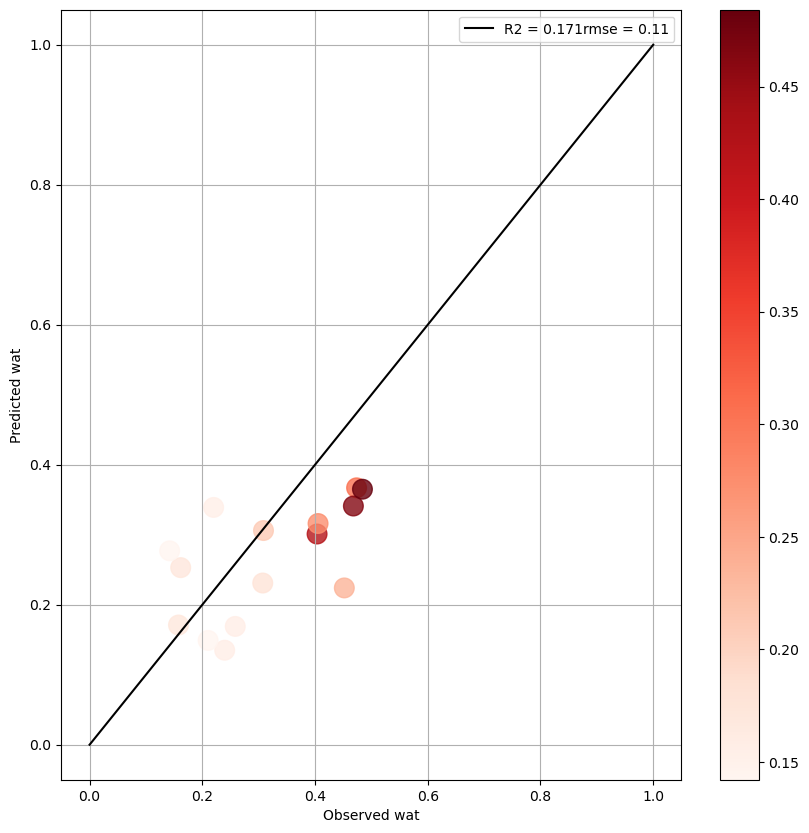

In [30]:
bulk_ec_dc_050 = []

for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.50'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_050.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_050'] = bulk_ec_dc_050
ds_all_50cm = ds_all.loc[ds_all['depth']==50].reset_index(drop=True)

wat = []
# Calculating water
for i in range(len(ds_all_50cm.bulk_ec_dc_050)):
    res = minimize(objective_func_wat, 0.15, args=(ds_all_50cm.clay.mean(), ds_all_50cm.bd.mean(), 2.65, ds_all_50cm.water_ec_hp.mean(), 0, np.nan, np.nan, ds_all_50cm.bulk_ec_dc_050[i]), bounds=[(0, .65)] )
    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

r2_50cm = r2_score(ds_all_50cm.vwc.values, wat)
rmse_50cm = rmse(ds_all_50cm.vwc.values, wat)

# ************************************ PLOT *********************************** #
scale =  ds_all_50cm.clay
pcm = axes.pcolormesh([scale], vmin=np.min(ds_all_50cm.vwc), vmax=np.max(ds_all_50cm.vwc), cmap='Reds')

fig, axes = plt.subplots(figsize=[10, 10])
ss = 200

ax_lab = fig.colorbar(pcm, extend="neither", ax=axes)

# Plot predicted property vs EC
axes.scatter(ds_all_50cm.vwc, wat, s = ss, alpha=0.8, c = scale[:15], cmap = 'Reds')

axes.plot([0, 1], [0, 1], color = 'black', label = 'R2 = '+str(round(r2_50cm, 3)) + 'rmse = '+str(round(rmse_50cm, 3)))
axes.set_xlabel("Observed wat")
axes.set_ylabel("Predicted wat")
axes.legend()
axes.grid(True)

#for index, row in ds_all_10cm.iterrows():
#    axes.text(row['clay'], ds_all_10cm[index], str(int(row['name'])), alpha = 0.5, fontsize=12)

plt.show()